# Data Manipulation

Data manipulation: 
    1. remove duplicate rows
    2. add last day's volumn, open interest rate, closing price for each option 
    3. add last week's volumn, open interest rate, closing price for each option
    4. add last day's sp500 price and last week's price 
    5. select options whose today's sp500 price is within 30 of strike price 
    5. remove rows with null values
    6. group all the options corresponding to their (settlement date, today's date) and pick all the interested features

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

In [2]:
def readToDataFrame(input):
    """ read data from input path 
        drop duplicates
        and return dataframe where settle date and todaydate is transfferd to datetime format
    """
    optiondata = pd.read_table( input, delimiter = ",")
    todaydate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.todaydate]
    optiondata.todaydate = todaydate_tmp
    settledate_tmp = [pd.datetime.strptime(str(x), '%Y%m%d') for x in optiondata.settledate]
    optiondata.settledate = settledate_tmp
    return optiondata.drop_duplicates()
optiondata = readToDataFrame("relevantoptions2")

In [3]:
# create dictionary to store everyday's sp500 price

def createPriceDict(row, pricedict):
    if not pricedict.has_key(row['todaydate'].strftime("%B %d, %Y")):
        pricedict[row['todaydate'].strftime("%B %d, %Y")] = row['today_sp_price']

def getPrice(df):
    """get vol and sp500 today price for each day
    """
    price = {}
    df.apply(lambda row: createPriceDict(row, price), axis=1)
    return price

priceDict = getPrice(optiondata)

In [4]:
# create dictionary to store every option's volumn, open interest rate, closing price for each day 
# option can be identified by settledate, optiontype, option strike
def createOptionDict(row, optdict):
    if not optdict.has_key((row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])):
        optdict[(row['todaydate'],row['settledate'],row['optiontype'],row['optionstrike'])] = (row['optionvol'],
                    row['optionopenint'], row['optionclosingprice'])
        
def getOption(df):
    """get vol and sp500 today price for each day 
    """
    optionDic = {}
    df.apply(lambda row: createOptionDict(row, optionDic), axis=1)
    
    return optionDic

optionDic = getOption(optiondata)

In [5]:
#add sp500 yesterday's and last week's price 
def prevPrice1d(row, priceDic):
    i = 1;
    while (i < 5):
        if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
            return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
        else:
            i+=1
    return 0

def prevPrice1week(row, priceDic):
    i = 7;
    if priceDic.has_key((row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")):
        return priceDic[(row['todaydate']-datetime.timedelta(i)).strftime("%B %d, %Y")]
    return 0


def addPrevPrice(df, priceDic):
    """ add s&p price of previous n days to dataframe
    """
    prvPrice =  df.apply(lambda row: prevPrice1d(row, priceDic), axis=1)
    df['sp1d'] = prvPrice
    prvweekPrice =  df.apply(lambda row: prevPrice1week(row, priceDic), axis=1)
    df['sp1w'] = prvweekPrice

addPrevPrice(optiondata,priceDict)

In [6]:
# add option's yesterday and last week's vol, openint and closing price 

def prevOption1d(row, optionDic):
    i = 1;
    while (i < 5):
        if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
            return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
        else:
            i += 1
    return -1

def prevOption1w(row, optionDic):
    i = 7;
    if optionDic.has_key((row['todaydate'] - datetime.timedelta(i),row['settledate'],row['optiontype'],row['optionstrike'])):
        return optionDic[((row['todaydate'] - datetime.timedelta(i)),row['settledate'],row['optiontype'],row['optionstrike'])]
    return -1


def addOptionDay(df, optionDic):
    # add option volume of previous n days to dataframe
    prevoptionday = df.apply(lambda row: prevOption1d(row, optionDic), axis=1)
    #print prevoptionday.head(20)
    df['volopenint%closing1d'] = prevoptionday
    prevoptionweek = df.apply(lambda row: prevOption1w(row, optionDic), axis=1)
    df['volopenint%closing1w'] = prevoptionweek
    

addOptionDay(optiondata, optionDic)
optiondata.to_csv("optiondata1", index=False)

### some analysis

In [7]:
# select options that whose today's 500 price is within 30 of strike price 
within30data = optiondata[abs(optiondata.today_sp_price - optiondata.optionstrike)<=30]
within100data = optiondata[abs(optiondata.today_sp_price - optiondata.optionstrike)<=100]
print within100data.describe()
print within30data.describe()
print optiondata.describe()
haslastweek = within30data[within30data['volopenint%closing1w'] == -1]
haslastweek.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  50972.000000    50972.000000     50972.000000  50972.000000   
mean       8.846916     2061.976291      2033.339005   2056.049203   
std        5.162944      147.659176       283.048013    154.469532   
min        2.000000     1630.480000         0.000000   1535.000000   
25%        4.000000     1979.920000      1970.890000   1970.000000   
50%        8.000000     2077.990000      2076.780000   2060.000000   
75%       14.000000     2127.020000      2126.640000   2140.000000   
max       19.000000     2480.910000      2477.130000   2570.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        50972.000000     50972.000000    50972.000000  50972.000000   
mean            13.930316        14.360437       13.385268   1863.632524   
std             19.991088        20.432921       19.534349   3487.394012   
min              0.025000         0.000000        0.000000      0

,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionhighprice,optionlowprice,optionvol,optionopenint,sp1d,sp1w
count,10832.000000,10832.000000,10832.000000,10832.000000,10832.000000,10832.000000,10832.000000,10832.000000,10832.000000,10832.000000,10832.00000
mean,10.644479,2054.628209,2018.202365,2054.335303,15.885429,16.320453,15.277257,1945.345919,11702.516710,2031.036646,1834.04260
std,5.528732,160.407476,309.757518,161.185026,11.537497,11.876228,11.308783,3338.514753,13276.528583,261.249123,640.20118
min,2.000000,1630.480000,0.000000,1610.000000,0.075000,0.000000,0.000000,0.000000,5001.000000,0.000000,0.00000
25%,4.000000,1959.530000,1960.960000,1960.000000,6.500000,6.700000,6.000000,0.000000,6050.000000,1951.270000,1895.02500
50%,11.000000,2067.890000,2067.560000,2065.000000,13.650000,14.000000,13.100000,526.000000,7668.000000,2065.300000,2047.83000
75%,16.000000,2125.770000,2122.730000,2130.000000,23.050000,23.700000,22.400000,2606.000000,11223.750000,2119.210000,2109.84000
max,19.000000,2480.910000,2477.130000,2510.000000,87.200000,91.200000,83.200000,62304.000000,165591.000000,2480.910000,2477.83000


Summary

At first, we have 55139 rows;

There are 49326 options whose price is within 100 of strikeprice;

18479 options whose price is within 30 of strikeprice;

Out of 18479 options, 10367 of them don't exist exactly one week before

In [8]:
# add closing price, vol and open interest of  yesterday 
def closing1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionclosingprice']
    else:
        return row['volopenint%closing1d'][2]

def addClosing1d(df):
    """ yesterday's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1day(row), axis=1)
    df['closing1day'] = prvPrice
    
def vol1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionvol']
    else:
        return row['volopenint%closing1d'][0]

def addvol1d(df):
    """ yesterday's volume
    """
    prvVol =  df.apply(lambda row: vol1day(row), axis=1)
    df['vol1day'] = prvVol
    #df['prevPrice1d'].hist()
    
def opint1day(row):
    if row['volopenint%closing1d'] == -1:
        return row['optionopenint']
    else:
        return row['volopenint%closing1d'][1]

def addopint1d(df):
    """ yesterday's volume
    """
    
    prvopen =  df.apply(lambda row: opint1day(row), axis=1)
    df['opint1day'] = prvopen
    #df['prevPrice1d'].hist()

def addYesterdayData(df):
    addClosing1d(df)
    addvol1d(df)
    addopint1d(df)

addYesterdayData(within30data)


/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [9]:
# add closing price, vol and open interest of  lastweek
def closing1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['closing1day']
    else:
        return row['volopenint%closing1w'][2]

def addClosing1w(df):
    """ last week's closing price
    """
    prvPrice =  df.apply(lambda row: closing1w(row), axis=1)
    df['closing1w'] = prvPrice
    
def vol1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['vol1day']
    else:
        return row['volopenint%closing1w'][0]

def addvol1w(df):
    """ last week's volume
    """
    prvVol =  df.apply(lambda row: vol1w(row), axis=1)
    df['vol1w'] = prvVol
    
def opint1w(row):
    if row['volopenint%closing1w'] == -1:
        return row['opint1day']
    else:
        return row['volopenint%closing1w'][1]

def addopint1w(df):
    """ yesterday's open interest
    """
    prvopen =  df.apply(lambda row: opint1w(row), axis=1)
    df['opint1w'] = prvopen

def addLastWeekData(df):
    addClosing1w(df)
    addvol1w(df)
    addopint1w(df)

addLastWeekData(within30data)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [12]:
print within30data.describe()

       daystosettle  today_sp_price  settle_sp_price  optionstrike  \
count  18479.000000    18479.000000     18479.000000  18479.000000   
mean       8.697819     2046.839030      2052.967210   2046.591536   
std        5.140933      131.784089       133.459303    132.671996   
min        2.000000     1630.480000      1632.970000   1610.000000   
25%        4.000000     1973.280000      1970.890000   1970.000000   
50%        8.000000     2071.920000      2075.370000   2070.000000   
75%       14.000000     2115.480000      2122.730000   2125.000000   
max       19.000000     2369.750000      2381.920000   2395.000000   

       optionclosingprice  optionhighprice  optionlowprice     optionvol  \
count        18479.000000     18479.000000    18479.000000  18479.000000   
mean            15.118914        15.593920       14.492343   2399.733806   
std             11.043623        11.376337       10.802911   4025.838160   
min              0.075000         0.000000        0.000000      0

we found that distribution of top 25% vol are 0 which means they may not be stable. So we ignore features related to vol

In [10]:
#add ratios for closing price and openinterest: today price/ yesterday price and today price/ last week's price
# if the option doesn't exist one week before, the ratio will be the same as today price/ yesterday's price

def closing1dayratio(row):
    return row['optionclosingprice']/row['closing1day']

def addClosing1dratio(df):
    prvPrice =  df.apply(lambda row: closing1dayratio(row), axis=1)
    df['closing1dayratio'] = prvPrice
    
    
def opint1dayratio(row):
    return float(row['optionopenint'])/row['opint1day']

def addopint1dratio(df):
    prvopen =  df.apply(lambda row: opint1dayratio(row), axis=1)
    df['opint1dayratio'] = prvopen
    #df['prevPrice1d'].hist()

def closing1wratio(row):
    return row['optionclosingprice']/row['closing1w']

def addClosing1wratio(df):
    """ last week's closing price
    """
    
    prvPrice =  df.apply(lambda row: closing1wratio(row), axis=1)
    df['closing1wratio'] = prvPrice
    
def opint1wratio(row):
     return float(row['optionopenint'])/row['opint1w']

def addopint1w(df): 
    prvopen =  df.apply(lambda row: opint1wratio(row), axis=1)
    df['opint1wratio'] = prvopen
    

def addRatio(df):
    addopint1w(df)
    addClosing1wratio(df)
    addopint1dratio(df)
    addClosing1dratio(df)
    
addRatio(within30data)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [14]:
##check whether result is right 
print within30data.count()
print within30data[within30data['closing1wratio']==within30data['closing1dayratio']].count()
# this is consistent with  " And there are 10367 of them that doesn't exist exactly one week before"

todaydate               18479
settledate              18479
daystosettle            18479
today_sp_price          18479
settle_sp_price         18479
optiontype              18479
optionstrike            18479
optionclosingprice      18479
optionhighprice         18479
optionlowprice          18479
optionvol               18479
optionopenint           18479
sp1d                    18479
sp1w                    18479
volopenint%closing1d    18479
volopenint%closing1w    18479
closing1day             18479
vol1day                 18479
opint1day               18479
closing1w               18479
vol1w                   18479
opint1w                 18479
opint1wratio            18479
closing1wratio          18479
opint1dayratio          18479
closing1dayratio        18479
dtype: int64
todaydate               10384
settledate              10384
daystosettle            10384
today_sp_price          10384
settle_sp_price         10384
optiontype              10384
optionstrike            103

In [135]:
#remove unrelated columns 
cleandata = within30data.drop(['optionhighprice','optionlowprice','optionvol','volopenint%closing1d',
                               'volopenint%closing1w','closing1day','vol1day','opint1day','closing1w',
                               'vol1w','opint1w'], axis=1)
cleandata = cleandata[cleandata['sp1d']!=0]
cleandata = cleandata[cleandata['sp1w']!=0]
cleandata.describe()



,daystosettle,today_sp_price,settle_sp_price,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio
count,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000,18026.000000
mean,8.701542,2061.294941,2023.824079,2060.991901,14.867998,13951.118052,2059.877030,2055.668690,1.135928,1.241096,1.045241,1.116817
std,5.148558,149.234867,304.578485,149.973093,10.988184,15027.471294,149.262117,149.519533,0.310362,1.537346,0.147369,0.743410
min,2.000000,1630.480000,0.000000,1610.000000,0.075000,5001.000000,1630.480000,1630.480000,0.301567,0.021718,0.301567,0.087121
25%,4.000000,1978.090000,1970.890000,1975.000000,5.850000,6735.250000,1975.890000,1969.410000,1.000000,0.671010,0.998462,0.763747
50%,8.000000,2077.990000,2075.370000,2075.000000,12.650000,9314.000000,2077.570000,2077.990000,1.024839,1.000000,1.002607,1.000000
75%,14.000000,2126.345000,2126.060000,2130.000000,22.000000,14397.000000,2126.410000,2124.020000,1.171766,1.274952,1.055889,1.215909
max,19.000000,2480.910000,2477.130000,2510.000000,87.200000,175350.000000,2480.910000,2477.830000,5.587633,33.857143,4.768577,12.344828


### group options belong to same (today's date and settlement date)
If we use 20 options in a row, there will be only 109 observations and 203 features, so I  combine top 15 options for each pair 
1. Next, we are going to put the first 15 options that has strike price closest to today's sp500 corresponding to the same (today date, settlement date) in one row according to following steps:
2. sort data according to their absolute value of (strike price - today's sp500 price)
3. create a dictionary, whose key is (today date, settlement date) pair and value is a list of our interested feature of each option.(suppose m vecor for each element)
4. add each option in the dictionary.
5. adjust each dict value to include 15 options 
6. sort data accoridng to settledate and if settledate are the same, sort the data based on today's date.



In [136]:
def getOptionType(row):
    if row['optiontype']=='put':
        return 0
    else: 
        return 1
def changeType(df):
    df['type'] = df.apply(lambda row: getOptionType(row), axis = 1 )
    df['optiontype']=df['type']
    


def diffStrikeSp500(row):
    return abs(row['optionstrike']-row['today_sp_price'])
def sortAbs(df):
    df['abs'] = df.apply(lambda row: diffStrikeSp500(row), axis = 1 )
    return df.sort_values(by = 'abs') 

changeType(cleandata)
cleandata = sortAbs(cleandata)

In [146]:
## adjust dictionary to include only 15 options
def adjustDic(myDict):
    for k, v in myDict.items():
        if len(v) < 153:
            #print len(myDict[k])
            del myDict[k]
        else:
            #print len(myDict[k])
            myDict[k] = myDict[k][:153]
    
adjustDic(myDic)
df3=pd.DataFrame.from_dict(myDic)
df4 = df3.T
df4.reset_index(inplace=True)
df5 = df4.rename(columns={'level_1': 'settledate', 'level_0': 'todaydate'})
df5.to_csv("combinedoption2", index=False)

33
73
83
63
23
143
113
73
63
153
13
53
43
143
83
123
43
203
53
33
73
113
233
53
143
93
33
43
33
83
113
113
93
23
123
23
103
203
113
43
43
43
33
63
173
13
133
73
23
33
33
143
123
63
13
83
93
53
213
23
43
53
113
243
133
143
123
53
123
113
113
93
33
13
153
103
13
63
33
103
13
43
93
153
53
103
83
103
213
123
43
43
113
93
223
243
93
123
103
53
23
93
43
63
63
73
103
33
143
13
23
33
43
143
133
13
103
243
83
83
143
23
243
33
63
53
53
233
53
53
193
13
73
33
93
23
203
23
133
53
83
33
43
13
73
83
163
133
113
113
113
33
43
123
53
43
103
133
13
363
113
173
63
33
83
33
73
63
23
63
43
53
43
53
13
73
23
123
153
323
73
93
63
103
43
73
93
13
13
53
103
23
103
113
53
233
383
263
43
43
53
53
93
63
233
113
143
13
23
63
63
223
73
83
53
43
233
73
53
243
163
83
113
43
53
73
23
123
83
73
53
53
193
133
273
13
53
13
193
153
93
53
133
113
63
113
103
93
43
33
13
83
13
93
83
43
63
123
83
53
93
103
143
53
43
93
13
23
13
153
13
233
33
83
53
83
33
23
153
83
123
253
73
13
83
153
163
83
83
123
53
43
203
83
123
103
53
103

In [18]:
def adjustDic(myDict):
    for k, v in myDict.items():
        if len(v) < 153:
            #print len(myDict[k])
            del myDict[k]
        else:
            myDict[k] = myDict[k][:153]
    
adjustDic(myDic)
df3=pd.DataFrame.from_dict(myDic)
df4 = df3.T
df4.reset_index(inplace=True)
df5 = df4.rename(columns={'level_1': 'settledate', 'level_0': 'todaydate'})
df5.to_csv("combinedoption2", index=False)

Summary:
1. df5 is after we combine options belong to same (today's date, settle date)
2. clean data is optiondata before combining
3. After combining options belong to the same pair, we got 276 rows and 153 features for each pair(column)                                                   
                                                   

# Training

Random Forest Regressor
    1. we divide trainig set and test set based on settlement date. If a option's settledate is after the half of          2015,  we use it as test data; otherwise, training data.
    2. Target: settlement day's sp500 price - today's sp500 price
          X: ['optiontype','optionstrike',
         'optionclosingprice','optionhighprice', 'optionlowprice', 'optionopenint', 
          'sp1d','sp1w','opint1wratio',
        'closing1wratio','opint1dayratio','closing1dayratio'] for each option and ['daystosettle', 'today_sp_price']                 for all options belong to the same (settledate, toadaydate) pair. 
    3. Train a random forest regressor

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime

In [41]:
def target(row):
    return row[1] - row[2]

def addTarget(df):
    """ target = settle price - today's price
    """
    t = df.apply(lambda row: target(row), axis=1)
    df['target'] = t

addTarget(df5)

,todaydate,settledate,0,1,2,3,4,5,6,7,...,145,146,147,148,149,150,151,152,target,pred
0,2013-12-03,2013-12-06,3.0,1805.09,1795.15,1.0,1795.0,7.00,9884.0,1800.90,...,0.375,13515.0,1800.90,1802.75,1.050035,0.333333,1.050035,0.333333,9.94,8.67147
1,2013-12-04,2013-12-06,2.0,1805.09,1792.81,1.0,1795.0,6.55,10788.0,1795.15,...,1.900,7545.0,1795.15,1807.23,1.354092,0.791667,1.354092,0.791667,12.28,10.98839
2,2014-02-19,2014-02-28,9.0,1859.45,1828.75,0.0,1825.0,12.65,5500.0,1840.76,...,32.950,10166.0,1840.76,1819.26,1.895934,1.132302,0.996471,0.775294,30.70,25.53732
3,2014-02-26,2014-02-28,2.0,1859.45,1845.16,1.0,1845.0,6.15,7469.0,1843.09,...,0.400,24789.0,1843.09,1828.75,0.988161,0.695652,0.988161,0.695652,14.29,12.50253
4,2014-03-12,2014-03-14,2.0,1841.13,1868.20,1.0,1865.0,8.20,5263.0,1867.63,...,19.700,11149.0,1867.63,1873.81,1.092825,0.697345,0.957489,1.028721,-27.07,-14.55751
5,2014-04-09,2014-04-11,2.0,1815.69,1872.18,0.0,1870.0,6.20,5764.0,1851.96,...,22.500,8802.0,1851.96,1890.90,1.076697,2.153110,1.076697,2.153110,-56.49,-35.22301
6,2014-05-15,2014-05-23,8.0,1900.53,1870.85,1.0,1875.0,9.95,6739.0,1888.53,...,32.650,11294.0,1888.53,1875.63,1.000000,1.000000,1.000000,1.000000,29.68,23.04891
7,2014-06-02,2014-06-06,4.0,1949.44,1924.97,1.0,1925.0,6.80,10210.0,1923.57,...,29.350,7545.0,1923.57,1900.53,1.001327,1.037102,1.001327,1.037102,24.47,19.24068
8,2014-06-03,2014-06-06,3.0,1949.44,1924.24,1.0,1925.0,7.15,11204.0,1924.97,...,0.600,19208.0,1924.97,1911.91,1.325787,1.142857,1.325787,1.142857,25.20,20.46690
9,2014-06-04,2014-06-06,2.0,1949.44,1927.88,1.0,1930.0,6.35,12761.0,1924.24,...,28.450,11779.0,1924.24,1909.78,1.123522,1.635057,0.992501,1.131213,21.56,17.37571


In [21]:
mask1 = (df5['settledate'] < datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
training= df5.loc[mask1]
mask2 = (df5['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
test= df5.loc[mask2]

col_list = list(df5)
col_list[4:155]
x_list=[0]
x_list.extend(col_list[4:155])

X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]



regres = RandomForestRegressor(n_estimators=1000, max_features="sqrt", n_jobs=-1, oob_score = True)
regres.fit(X_train, y_train)
pred = regres.predict(X_test)
print("Mean squared error - Test Set: %.6f"
  % np.mean((pred - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_test, y_test))

pred_train = regres.predict(X_train)
print("Mean squared error - Training Set: %.6f"
  % np.mean((pred_train - y_train) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regres.score(X_train, y_train))




Mean squared error - Test Set: 170158.698790
Variance score: -0.02
Mean squared error - Training Set: 55.520246
Variance score: 0.91


### performance analysis

[[ 1.          0.20945057]
 [ 0.20945057  1.        ]]


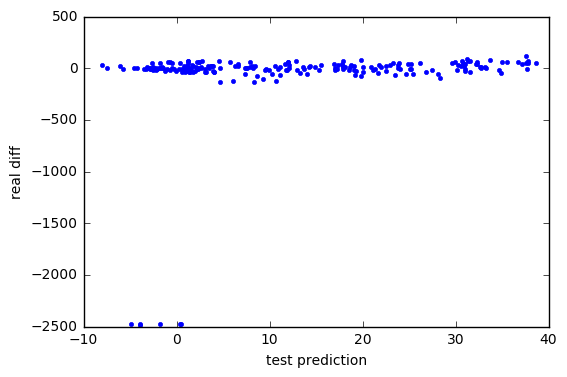

In [22]:
# scatter plot of real difference over prediction on test set
import numpy
plt.plot(pred, y_test, ".")
plt.ylabel('real diff')
plt.xlabel('test prediction')
print numpy.corrcoef(pred,y_test)

[[ 1.          0.99041292]
 [ 0.99041292  1.        ]]


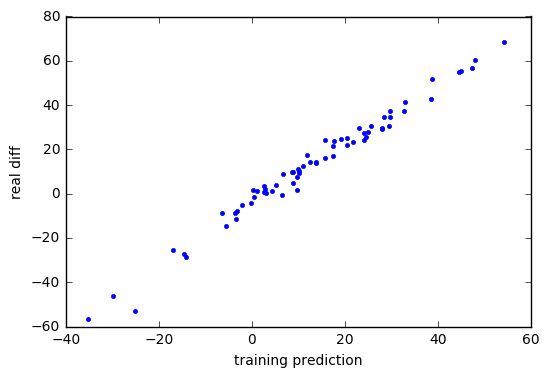

In [23]:
# scatter plot of real difference over prediction on training set 
plt.plot(pred_train, y_train, ".")
plt.ylabel('real diff')
plt.xlabel('training prediction')
print numpy.corrcoef(pred_train,y_train)

In [28]:
regres.oob_prediction_

array([  6.70505291,   4.36773224,  11.19826558,  10.00166205,
         8.05259669,   4.94099738,  14.5468    ,   6.72961644,
        10.54262338,   9.67234783,   0.08419558,   9.22598916,
        -1.41184987,   3.64866485,  -0.62002849,   5.29290761,
        19.38431937,  -2.16147453,   3.64704678,  17.24368116,
        25.96759104,  14.92337079,  14.39678063,  14.69408333,
        23.88053708,  17.9197043 ,   2.86929577,   5.13754522,
        22.35290055,  14.93677083,  28.27220159,   0.6490407 ,
         4.0197019 ,   9.0997654 ,   9.694573  ,  12.01495935,
        26.46204545,  28.33926431,  21.65297003,  26.40568783,
        28.58759259,  27.35710983,  28.43851429,  21.34656593,
        23.32790155,  11.44438642,  23.92865979,   6.52703412,
         7.08918848,  -3.68275281,  16.67371429,   0.56407713,
         7.26917143,   2.81506631,   3.64934659,   6.3271618 ,
         9.10191977,  14.51804233,  19.30757746,  29.7726361 ,
        24.29145889,  13.04921466,  10.05299728,  14.70

[[ 1.          0.76111121]
 [ 0.76111121  1.        ]]


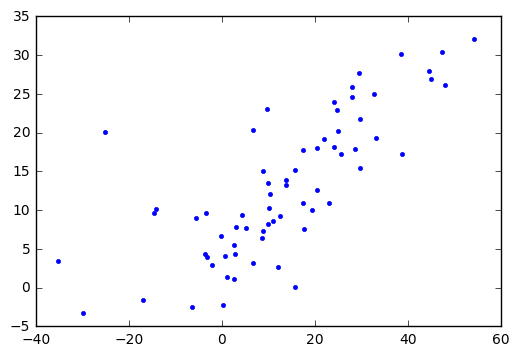

In [24]:
pred_train
plt.plot(pred_train, regres.oob_prediction_, ".")
print numpy.corrcoef(pred_train,regres.oob_prediction_)

# Strategies

### Add prediction to test set 

In [25]:
# get dictionary for ((today's date, settlement's date): prediction)
def createPredDict(row, pred_dict):
    if not pred_dict.has_key((row['todaydate'],row['settledate'])):
        pred_dict[(row['todaydate'],row['settledate'])] = row['pred']

def getPredict(df):
    """get predition for each today's date and settledate
    """
    prediction = {}
    df.apply(lambda row: createPredDict(row, prediction), axis=1)
    return prediction

predAll = numpy.append(pred_train,pred,axis=0)
df5['pred'] = predAll.tolist()
predDict = getPredict(df5)

# farward test
1.Date after 20170811 doesnt has settlement price
2.We want to get their settlement price prediction

In [40]:
df5

,todaydate,settledate,0,1,2,3,4,5,6,7,...,145,146,147,148,149,150,151,152,target,pred
0,2013-12-03,2013-12-06,3.0,1805.09,1795.15,1.0,1795.0,7.00,9884.0,1800.90,...,0.375,13515.0,1800.90,1802.75,1.050035,0.333333,1.050035,0.333333,9.94,8.67147
1,2013-12-04,2013-12-06,2.0,1805.09,1792.81,1.0,1795.0,6.55,10788.0,1795.15,...,1.900,7545.0,1795.15,1807.23,1.354092,0.791667,1.354092,0.791667,12.28,10.98839
2,2014-02-19,2014-02-28,9.0,1859.45,1828.75,0.0,1825.0,12.65,5500.0,1840.76,...,32.950,10166.0,1840.76,1819.26,1.895934,1.132302,0.996471,0.775294,30.70,25.53732
3,2014-02-26,2014-02-28,2.0,1859.45,1845.16,1.0,1845.0,6.15,7469.0,1843.09,...,0.400,24789.0,1843.09,1828.75,0.988161,0.695652,0.988161,0.695652,14.29,12.50253
4,2014-03-12,2014-03-14,2.0,1841.13,1868.20,1.0,1865.0,8.20,5263.0,1867.63,...,19.700,11149.0,1867.63,1873.81,1.092825,0.697345,0.957489,1.028721,-27.07,-14.55751
5,2014-04-09,2014-04-11,2.0,1815.69,1872.18,0.0,1870.0,6.20,5764.0,1851.96,...,22.500,8802.0,1851.96,1890.90,1.076697,2.153110,1.076697,2.153110,-56.49,-35.22301
6,2014-05-15,2014-05-23,8.0,1900.53,1870.85,1.0,1875.0,9.95,6739.0,1888.53,...,32.650,11294.0,1888.53,1875.63,1.000000,1.000000,1.000000,1.000000,29.68,23.04891
7,2014-06-02,2014-06-06,4.0,1949.44,1924.97,1.0,1925.0,6.80,10210.0,1923.57,...,29.350,7545.0,1923.57,1900.53,1.001327,1.037102,1.001327,1.037102,24.47,19.24068
8,2014-06-03,2014-06-06,3.0,1949.44,1924.24,1.0,1925.0,7.15,11204.0,1924.97,...,0.600,19208.0,1924.97,1911.91,1.325787,1.142857,1.325787,1.142857,25.20,20.46690
9,2014-06-04,2014-06-06,2.0,1949.44,1927.88,1.0,1930.0,6.35,12761.0,1924.24,...,28.450,11779.0,1924.24,1909.78,1.123522,1.635057,0.992501,1.131213,21.56,17.37571


In [26]:
## get dataframe for testing
mask3 = (cleandata['settledate'] > datetime.strptime('Jun 30 2015  1:33PM', '%b %d %Y %I:%M%p'))
testdf= cleandata.loc[mask3]


In [27]:
## add sp500 difference predction to each option

def getPred(row,pred_dict):
    if pred_dict.has_key((row['todaydate'],row['settledate'])):
        return pred_dict[(row['todaydate'],row['settledate'])]
    else:
        return 0

def changePred(df, pred_dict):
    pred0 = df.apply(lambda row: getPred(row, pred_dict), axis=1)
    df['pred'] = pred0
        
changePred(testdf, predDict)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## First Strategy

In [34]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price and row.optiontype == 0: #put
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price and row.optiontype == 1: #call
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/i

In [35]:
## result of first strategy
positivedf = testdf 
neagtivedf = testdf 
positivedf = testdf[testdf.pl > 0]
negativedf = testdf[testdf.pl < 0]

In [37]:
print negativedf.describe()
print positivedf.describe()
print "profit is "+ str(positivedf['pl'].sum())
print "loss is " + str(negativedf['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    230.000000      230.000000       230.000000  230.000000   
mean       7.026087     2104.005130      2064.948478    0.208696   
std        5.080936       91.313192       128.756629    0.407263   
min        2.000000     1923.670000      1880.020000    0.000000   
25%        3.000000     2077.070000      1970.890000    0.000000   
50%        4.000000     2088.870000      2023.040000    0.000000   
75%       10.000000     2170.950000      2147.260000    0.000000   
max       18.000000     2328.250000      2347.220000    1.000000   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    230.000000          230.000000     230.000000   230.000000   
mean    2095.956522            9.579457   18737.317391  2101.987478   
std      100.953739            5.527485   17925.982811    92.091773   
min     1895.000000            0.225000    5002.000000  1893.360000   
25%     2055.000000            5

testdf is all the options that we are going to trade.

putdf are put options and calldf are call options

generate scatter points for put and call option where x axis is prediction and y is profit

In [39]:
interestedDf = testdf
interestedDf = testdf[testdf.pl!=0]
putDf = interestedDf[interestedDf.optiontype == 0]
callDf = interestedDf[interestedDf.optiontype == 1]

In [40]:
print putDf.describe()
print callDf.describe()

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    941.000000      941.000000       941.000000       941.0   
mean       8.153029     2060.514198      2068.075590         0.0   
std        5.093171       84.206958        92.192552         0.0   
min        2.000000     1851.860000      1880.020000         0.0   
25%        3.000000     1995.310000      2023.040000         0.0   
50%        8.000000     2075.000000      2075.150000         0.0   
75%       11.000000     2099.600000      2091.690000         0.0   
max       18.000000     2293.080000      2347.220000         0.0   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    941.000000          941.000000     941.000000   941.000000   
mean    2044.723698           12.636637   20886.708820  2058.755175   
std       84.681997            7.993001   21773.077388    86.440320   
min     1825.000000            0.425000    5002.000000  1852.210000   
25%     1980.000000            6

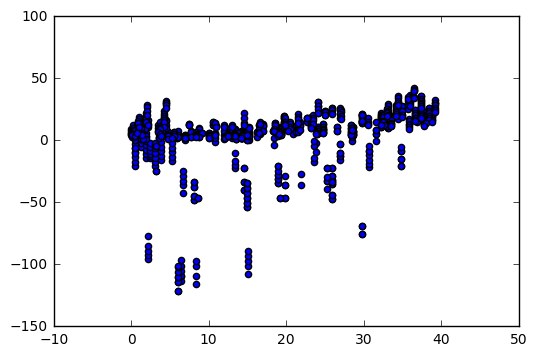

In [41]:
plt.scatter(putDf['pred'], putDf['pl'])

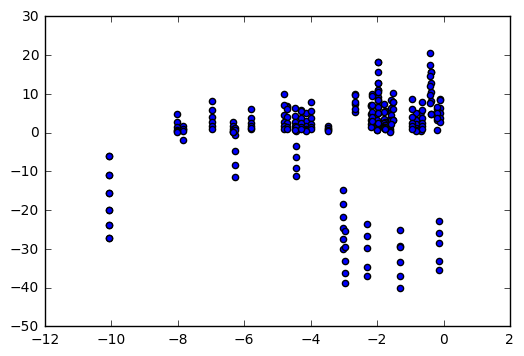

In [42]:
plt.scatter(callDf['pred'], callDf['pl'])

## Second Strategy

In [43]:
testdf2 = testdf
testdf2['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike <= row.today_sp_price - row.pred and row.optiontype == 0:
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price  - row.pred and row.optiontype == 1:
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0
            
    
getPl(testdf2, predDict)
testdf2['pl'].fillna(0, inplace=True)
    

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### result of second strategy

In [44]:
positivedf2 = testdf2 
neagtivedf2 = testdf2 
positivedf2 = testdf2[testdf2.pl > 0]
negativedf2 = testdf2[testdf2.pl < 0]
print negativedf2.describe()
print positivedf2.describe()
print "profit is "+ str(positivedf2['pl'].sum())
print "loss is " + str(negativedf2['pl'].sum())

       daystosettle  today_sp_price  settle_sp_price  optiontype  \
count    129.000000      129.000000       129.000000  129.000000   
mean       7.635659     2142.470233      2111.193333    0.310078   
std        5.237989       80.471301       131.947255    0.464328   
min        2.000000     1938.680000      1880.020000    0.000000   
25%        3.000000     2081.720000      2012.370000    0.000000   
50%        7.000000     2112.130000      2077.990000    0.000000   
75%       11.000000     2201.720000      2246.190000    1.000000   
max       18.000000     2328.250000      2347.220000    1.000000   

       optionstrike  optionclosingprice  optionopenint         sp1d  \
count    129.000000          129.000000     129.000000   129.000000   
mean    2134.883721            7.206008   20970.798450  2139.811938   
std       95.462413            4.758201   18334.461745    79.030991   
min     1910.000000            0.225000    5055.000000  1923.670000   
25%     2070.000000            3

### seperate analysis of call and put option 

In [46]:
interestedDf2 = testdf2
interestedDf2 = testdf2[testdf2.pl!=0]
putDf2 = interestedDf2[interestedDf2.optiontype == 0]
callDf2 = interestedDf2[interestedDf2.optiontype == 1]

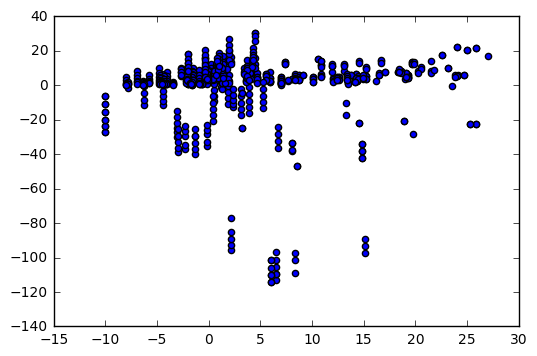

In [47]:
## scatter plot of put options' prediction over its P&l
plt.scatter(putDf2['pred'], putDf2['pl'])


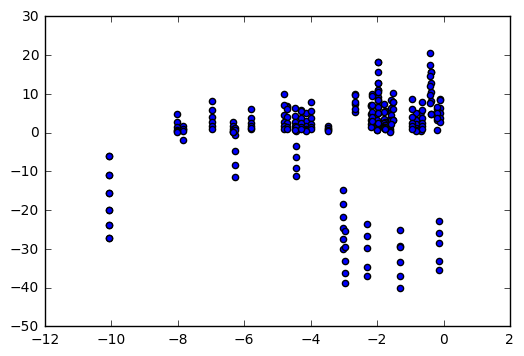

In [48]:
## scatter plot of call options' prediction over its P&l
plt.scatter(callDf['pred'], callDf['pl'])

### analysis based on the days to settle date

In [50]:
X_test = test.as_matrix(x_list)
y_test = test.as_matrix(['target'])[:,0]

X_train = training.as_matrix(x_list)
y_train = training.as_matrix(['target'])[:,0]
pred = regres.predict(X_test)
pred_train = regres.predict(X_train)



In [51]:
# convert X_test, y_test, pred to df
df6 = pd.DataFrame(X_test.tolist())
df6['real'] = y_test.tolist()
df6['pred'] = pred.tolist()

In [52]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row[0] not in dayList:
        dayList.append(row[0])

def getDayDiff(df):
    """get vol and sp500 today price for each day
    """
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(df6)

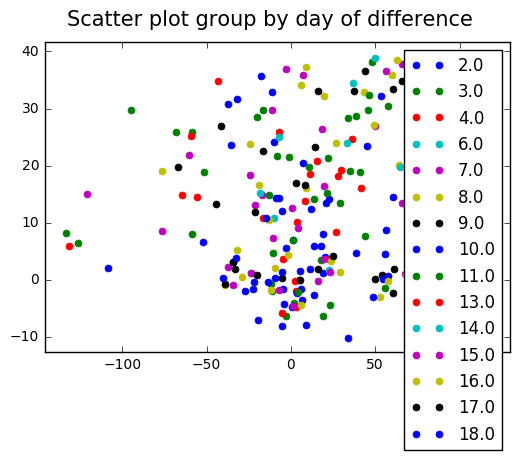

In [53]:
groups = df6.groupby(0)
fig, ax = plt.subplots()
fig.suptitle('Scatter plot group by day of difference', fontsize=15)
ax.margins(0.05) 
for name, group in groups:
    ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
ax.legend()

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


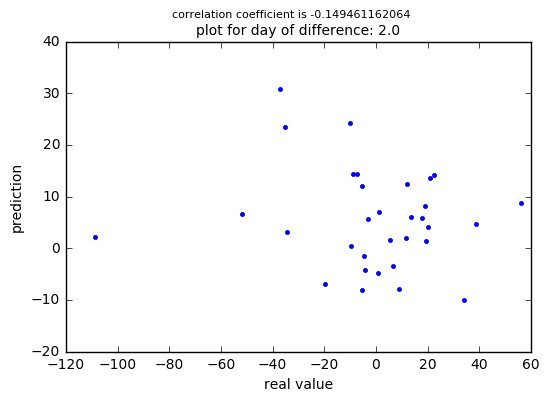

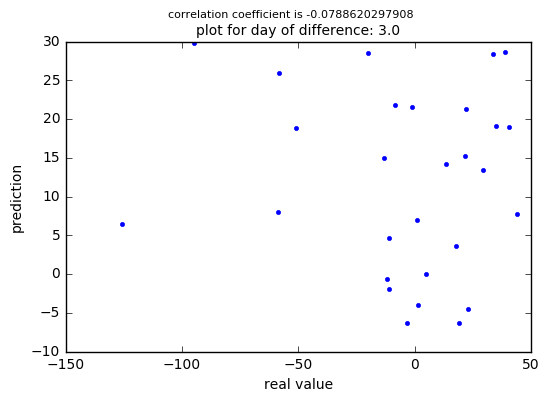

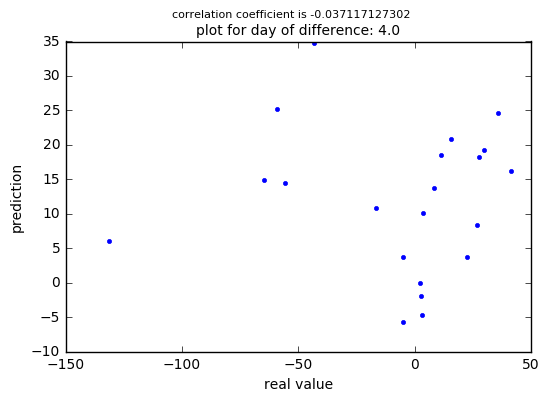

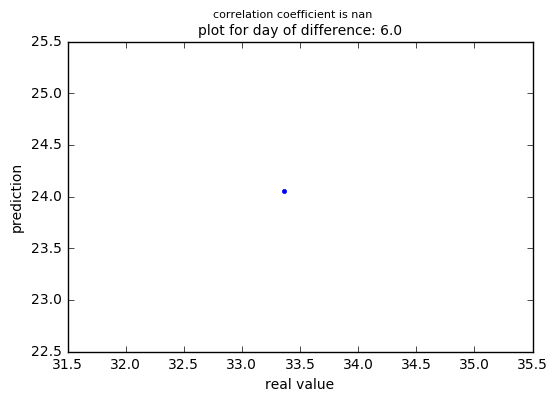

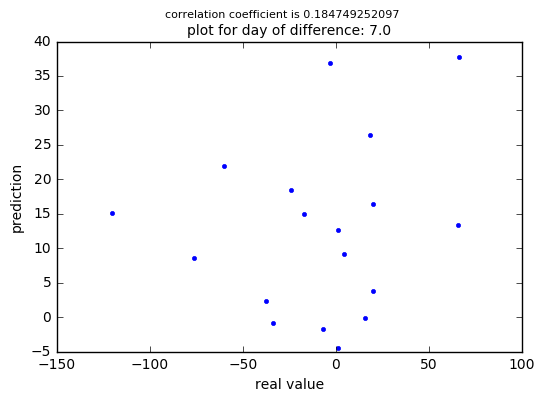

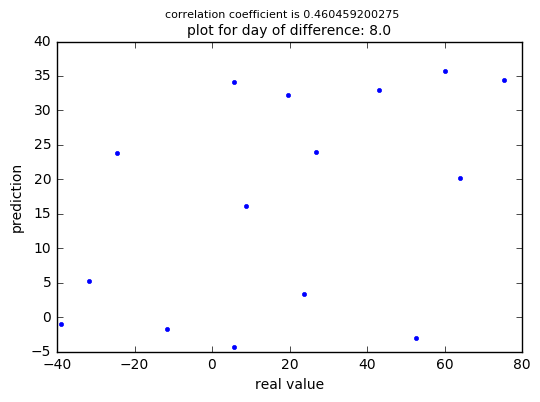

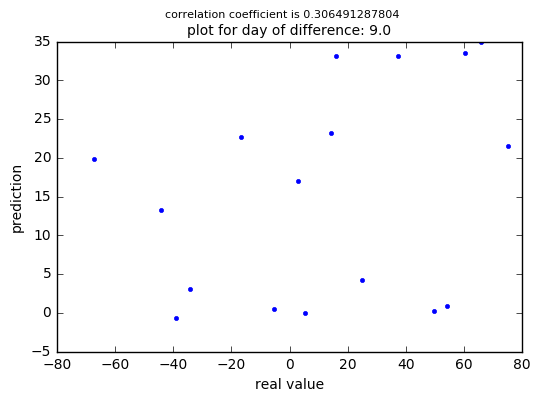

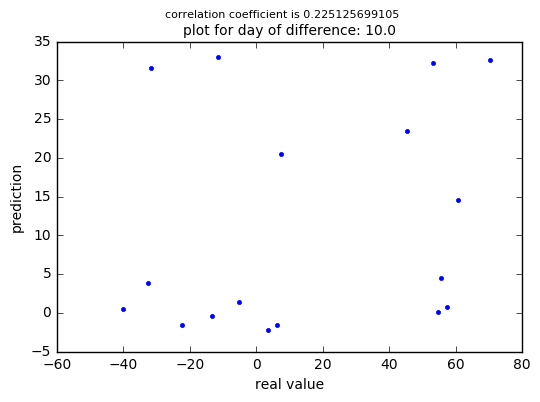

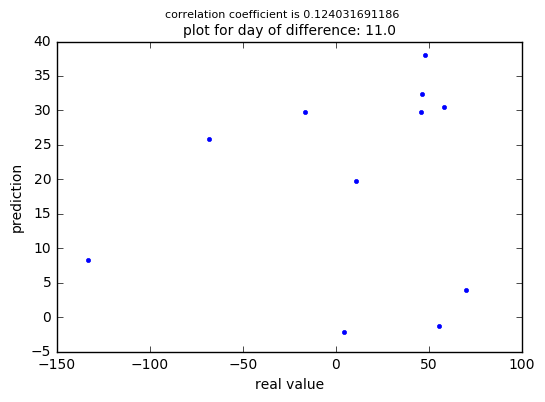

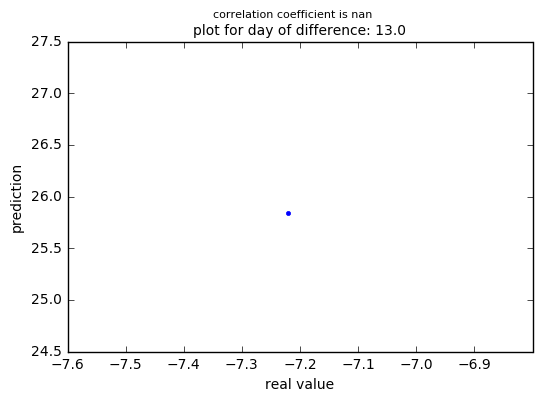

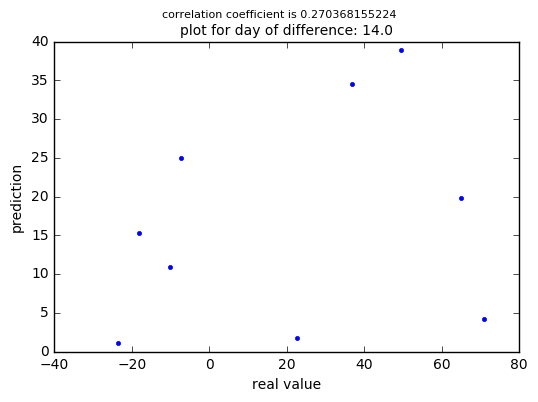

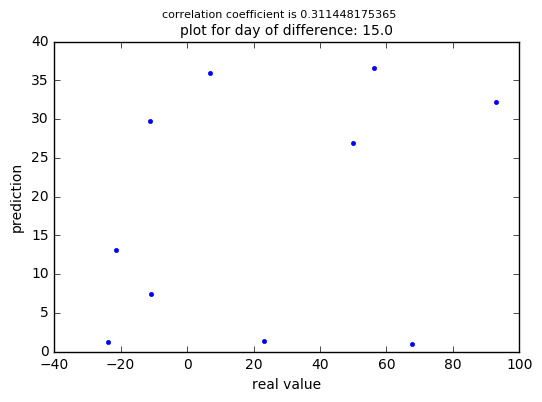

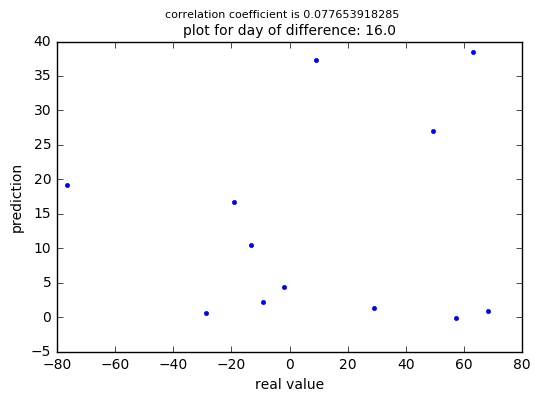

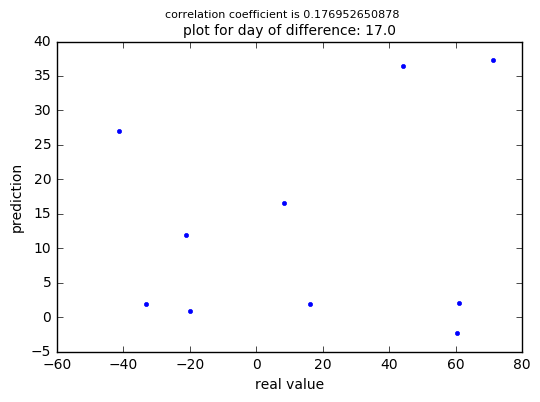

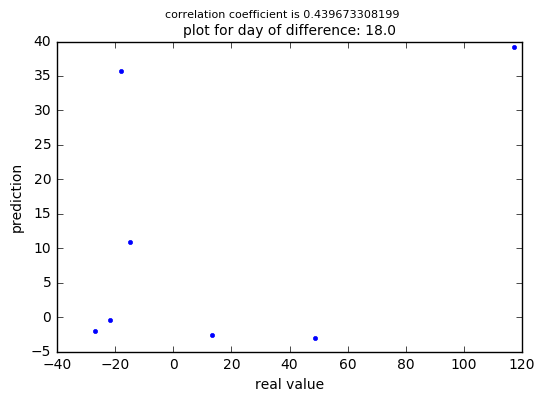

In [54]:
## generate correlation group by day of difference one by one, calculate correlation coefficient 
corrList = []
def oneDayDiff(key, df):
    df0 = df
    df0 = df[df[0]==key]
    fig = plt.figure()
    plt.xlabel('real value')
    plt.ylabel('prediction')
    plt.title('plot for day of difference: ' + str(key),  fontsize=10)
    plt.suptitle('correlation coefficient is '+ str(numpy.corrcoef(df0['real'],df0['pred'])[0][1]), fontsize=8)
    plt.plot(df0['real'], df0['pred'], ".")
    return numpy.corrcoef(df0['real'],df0['pred'])[0][1]
    
    
def allDayDiff(df, dayList, corr):
    for d in dayList:
        res = oneDayDiff(d, df)
        corr.append(res)
    return corr

corrList = allDayDiff(df6, dayDiffList, corrList)

## Third Startegy

In [56]:
testdf['pl']= 0

def compPL(row, pred_dict, multiplier):
    if row.pred == 0:
        return 0
    else:
        if row.pred > 0:
            if row.optionstrike < row.today_sp_price + row.optionclosingprice and row.optiontype == 0:
                if row.settle_sp_price >= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice + multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier + multiplier * (row.settle_sp_price - row.optionstrike)
        elif row.pred < 0:
            if row.optionstrike >= row.today_sp_price - row.optionclosingprice  and row.optiontype == 1:
                if row.settle_sp_price <= row.optionstrike:
                    #print row.optionclosingprice
                    return row.optionclosingprice*multiplier
                else:
                    #print row.optionclosingprice - multiplier * (row.settle_sp_price - row.optionstrike)
                    return row.optionclosingprice*multiplier - multiplier * (row.settle_sp_price - row.optionstrike)
        else:
            return 0
def getPl(df, pred_dict):
    pl0 = df.apply(lambda row: compPL(row, pred_dict, 1), axis=1)
    df['pl'] = pl0

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [58]:
### result of third strategy

In [59]:
getPl(testdf, predDict)
testdf['pl'].fillna(0, inplace=True)
interestedDf3 = testdf
interestedDf3 = testdf[testdf.pl!=0]

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
positivedf = interestedDf3
positivedf = interestedDf3[interestedDf3.pl > 0]
negadf = interestedDf3
negadf = interestedDf3[interestedDf3.pl < 0]

In [61]:
negadf.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,4.740000e+02
mean,7.067511,2106.656519,2076.518270,0.259494,2105.031646,16.557584,19301.643460,2105.696730,2109.652743,1.088077,1.166687,1.032069,1.081594,0.259494,14.063059,9.982798,-3.282474e+01
std,5.197137,98.379336,133.021079,0.438820,98.360498,9.444526,19927.860506,99.239716,89.126385,0.221838,1.048945,0.131986,0.540661,0.438820,8.651446,12.441685,3.038448e+01
min,2.000000,1890.280000,1880.020000,0.000000,1895.000000,0.225000,5002.000000,1893.360000,1851.860000,0.581292,0.071429,0.708325,0.173529,0.000000,0.000000,-10.073210,-1.311600e+02
25%,3.000000,2064.110000,1970.890000,0.000000,2060.000000,8.550000,7200.000000,2065.300000,2079.397500,0.994793,0.590716,0.990398,0.721191,0.000000,6.330000,-0.139310,-4.477000e+01
50%,4.000000,2094.650000,2040.040000,0.000000,2090.000000,15.825000,11321.000000,2099.130000,2099.330000,1.006182,0.981707,1.000000,1.000000,0.000000,13.680000,6.661970,-2.524500e+01
75%,10.000000,2179.980000,2187.020000,1.000000,2175.000000,23.287500,21959.750000,2176.120000,2180.380000,1.123259,1.115528,1.038984,1.215744,1.000000,21.397500,19.776800,-9.817500e+00
max,18.000000,2328.250000,2347.220000,1.000000,2345.000000,43.500000,132806.000000,2316.100000,2294.690000,2.291132,7.949367,2.107455,3.573333,1.000000,29.760000,34.752990,-4.263256e-14


In [62]:
positivedf.describe()

,daystosettle,today_sp_price,settle_sp_price,optiontype,optionstrike,optionclosingprice,optionopenint,sp1d,sp1w,opint1wratio,closing1wratio,opint1dayratio,closing1dayratio,type,abs,pred,pl
count,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000,1487.000000
mean,8.387357,2082.975999,2102.314378,0.218561,2078.954270,16.734294,21326.975790,2080.965138,2074.354593,1.097123,1.053904,1.034207,1.015994,0.218561,14.908911,15.619906,14.320387
std,5.094721,101.190654,95.233499,0.413409,103.335193,11.624840,22048.417459,102.069901,107.207291,0.236081,1.374418,0.110120,0.602348,0.413409,8.841815,14.975862,10.931913
min,2.000000,1851.860000,1880.330000,0.000000,1825.000000,0.225000,5005.000000,1852.210000,1851.860000,0.499007,0.021718,0.499007,0.087121,0.000000,0.000000,-8.036940,0.090000
25%,3.000000,1999.990000,2049.580000,0.000000,2000.000000,6.975000,7759.000000,1993.400000,1987.660000,0.999826,0.439463,0.996879,0.697043,0.000000,7.165000,0.899660,5.375000
50%,8.000000,2079.060000,2089.170000,0.000000,2070.000000,14.800000,13175.000000,2080.410000,2083.580000,1.021587,0.836570,1.003088,0.937500,0.000000,14.560000,14.393190,11.650000
75%,11.000000,2168.480000,2170.060000,0.000000,2165.000000,24.225000,24099.000000,2165.170000,2163.790000,1.132762,1.049433,1.042602,1.111111,0.000000,22.510000,30.487710,21.300000
max,18.000000,2328.250000,2347.220000,1.000000,2355.000000,56.200000,149669.000000,2316.100000,2298.370000,4.116423,14.444444,2.193734,4.575758,1.000000,29.990000,39.235960,55.850000


In [63]:
def plSummary(df):
    positivedf = df
    neagtivedf = df
    positivedf = df[df.pl > 0]
    negativedf = df[df.pl < 0]
    print "profit is "+ str(positivedf['pl'].sum())
    print "loss is " + str(negativedf['pl'].sum())

    
interestedDf3.describe()
plSummary(interestedDf3)

profit is 21294.415
loss is -15558.925


### calculate sharpe ratio based on days to settle date and plot P&l distribution based on days to settle date

In [64]:
#get day_difference list 
def createDayDiffDict(row, dayList):
    if row.daystosettle not in dayList:
        dayList.append(row.daystosettle)

def getDayDiff(df):
    dayDiff = []
    df.apply(lambda row: createDayDiffDict(row, dayDiff), axis=1)
    dayDiff.sort()
    return dayDiff

dayDiffList = getDayDiff(interestedDf3)

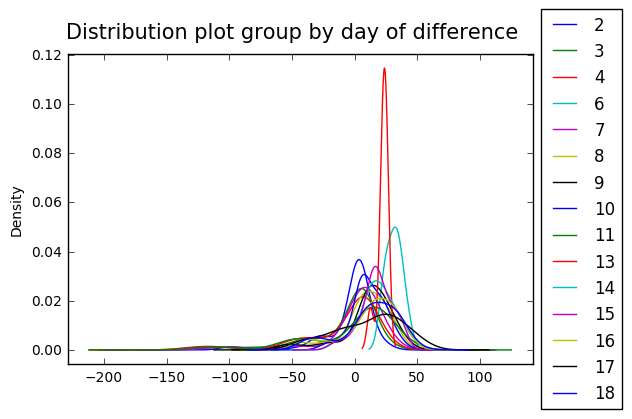

In [65]:
## draw pl distribution for each number of days 
def plotDistribution(df):
    groups = df.groupby('daystosettle')
    fig, ax = plt.subplots()
    fig.suptitle('Distribution plot group by day of difference', fontsize=15)
    ax.margins(0.05) 
    
    for name, group in groups:
        group.pl.plot(kind='kde', label=name)
        ##ax.plot(group.real, group.pred, marker='.', linestyle='', ms=10, label=name)
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
   
plotDistribution(interestedDf3)

In [66]:
def computeSharpeRatio(df):
    return df['pl'].mean() / df['pl'].std()

def getSharpeRatio(df):
    groups = df.groupby('daystosettle')
    res = []
    for name, group in groups:
        tmp = computeSharpeRatio(group)
        res.append((name, tmp))
    return res

SharpeList = getSharpeRatio(interestedDf3)
print SharpeList

[(2, -0.16071719196382112), (3, -0.27994212792715356), (4, -0.29643507984297596), (6, 4.8741661189301286), (7, -0.007739878978270282), (8, 0.45419014649332945), (9, 0.51249903926223273), (10, 0.82941549162392758), (11, -0.073704600255705202), (13, 5.611222538009363), (14, 1.3293559450765033), (15, 1.3659055129805246), (16, 0.51940776431427904), (17, 0.40015333581427176), (18, 0.56776639304163645)]


# Comparison with Random Startegies 

In [68]:
## get a sample of random profit 

import random 
def getSamples(num, testdf):
    res = []
    i = 1
    while i <= num:
        i += 1
        experimentalDf = testdf
        experimentalDf['pl'] = 0
        experimentalDf['buyorsell'] = 0
        getBuyOrSell(experimentalDf, options)
        getPl(experimentalDf)
        experimentalDf['pl'].fillna(0, inplace=True)
        res.append(experimentalDf['pl'].sum())
        print "profit is " + str(experimentalDf['pl'].sum())
    return res

# random choice either buy or sell or do nothing 
options = [-1,1, 0]

def getBuyOrSell(df, options):
    option = df.apply(lambda row: buyOrSell(row, options), axis=1)
    df['buyorsell'] = option

def buyOrSell(row, options):
    return random.choice(options)


# computer p&l based on the random choice
def compPL(row):
    if row.buyorsell == 0:
        return 0
    elif row.buyorsell == 1:
        pl = -row.optionclosingprice
        if row.optiontype == 1:
            if row.optionstrike < row.settle_sp_price:
                pl = pl + row.settle_sp_price - row.optionstrike
        else:
            if row.optionstrike > row.settle_sp_price:
                pl = pl + row.optionstrike - row.settle_sp_price
        return pl
    else:
        pl = row.optionclosingprice
        if row.optiontype == 1:
            if row.optionstrike < row.settle_sp_price:
                pl = pl -(row.settle_sp_price - row.optionstrike)
        else:
            if row.optionstrike > row.settle_sp_price:
                pl = pl -(row.optionstrike - row.settle_sp_price)
        return pl
        
def getPl(df):
    pl0 = df.apply(lambda row: compPL(row), axis=1)
    df['pl'] = pl0
            
sample = getSamples(10, testdf)

/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/mengranwang/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

profit is -272.19
profit is -382.895
profit is -2595.95
profit is -1104.705
profit is 3058.255
profit is 1814.425
profit is -1516.715
profit is -1532.285
profit is 2063.4
profit is -2012.26


In [69]:
## test weather third strategy and random starategy are from the same distribution
from scipy.stats import ttest_ind

## gen a list of PL from third strategy
def genStrategyList(res, num):
    i  = 1
    reslist = []
    while i <= num:
        i = i+1
        reslist.append(res)
    return reslist
stra3 = genStrategyList(6529,10)

## null hypothesis: third strategy and random starategy are from the same distribution; get p value
ttest_ind(sample,stra3)



Ttest_indResult(statistic=-11.164170300057313, pvalue=1.5988088428050065e-09)